# Home Temperature and Presence Prediction

This kernel is a personal training project. It aim's to predict the temperature in my appartment at a specific time to have the right temperature when I will be back home

In [329]:
import pandas as pd
import numpy as np
import time
import datetime
import tqdm
from matplotlib import pyplot

def format_as_min(val):
    if(int(val) < 10):
        return f'0{val}'
    return val

def get_hours_minus_x_min(hour, nb_min):
    return f'{hour[:2] if int(hour[-2:]) != 0 else int(hour[:2])-nb_min}:{ format_as_min(int(hour[-2:])-nb_min) if int(hour[-2:]) != 0 else 59 }'

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

DATA_PROPORTION = 5

Populating the interactive namespace from numpy and matplotlib


# Retrieve Data

In [330]:
data_home = pd.read_csv('./export_temperature.csv')
data_home = data_home[(data_home['date'].str.find('00:00:00.000000') == -1) & (data_home['temperature'] != 2147483647) & (data_home['id']%DATA_PROPORTION == 0)]
data_home = data_home.reset_index(drop=True)
data_plugs = pd.read_csv('./export_plugs.csv')
data_plugs = data_plugs[(data_plugs['date'].str.find('00:00:00.000000') == -1) & (data_home['id']%DATA_PROPORTION == 0)]
data_plugs = data_plugs.reset_index(drop=True)

data_lille = pd.read_csv('./export-lille.csv')

print(data_home.columns)
print(data_plugs.columns)


Index(['id', 'date', 'temperature', 'humidity', 'sensor_id'], dtype='object')
Index(['id', 'date', 'heater_status', 'plug_id'], dtype='object')


# Preprocessing Data

In [331]:
a_hours = []
a_prev_temp = []

data_plugs = data_plugs.assign(hour = pd.Series([ str() for i in range(data_plugs.shape[0])]))
j=0
for value in data_plugs.values:
    data_plugs.at[j, 'hour'] = value[4] = value[1].split(' ')[1].split('.')[0][:5]
    data_plugs.at[j, 'date'] = value[1] = value[1].split(' ')[0]
    j+=1

data_home = data_home.assign(prev_temp = pd.Series([ np.nan for i in range(data_home.shape[0])]))
data_home = data_home.assign(hour = pd.Series([ str() for i in range(data_home.shape[0])]))
data_home = data_home.assign(heater_on= pd.Series([ np.nan for a in range(len(a_prev_temp))]))

j=0
for value in data_home.values:
    data_home.at[j, 'hour'] = value[6] = value[1].split(' ')[1].split('.')[0][:5]
    data_home.at[j, 'date'] = value[1] = value[1].split(' ')[0]
    
    data = data_plugs[(data_plugs['date'] == value[1]) & ((data_plugs['hour'] == get_hours_minus_x_min(value[6], 1)) |(data_plugs['hour'] == value[6]) | (data_plugs['hour'] == get_hours_minus_x_min(value[6], -1)))].head(1)
    
    if len(data) == 1:
        # print(data_plugs[(data_plugs['date'] == value[1])])
        # print(data)
        # print(value[0], value[1], value[5])
        data_home.at[j, 'heater_on'] = data_plugs.iloc[data.index[0]]['heater_status']
    elif j+3 <= data_home.shape[0]-1:
        if data_home.at[j+3, 'temperature'] > data_home.at[j, 'temperature']:
            data_home.at[j, 'heater_on'] = 1
        else:
            data_home.at[j, 'heater_on'] = 0
    else:
        data_home.at[j, 'heater_on'] = 0
    
    if j!=0:
        data_home.at[j, 'prev_temp'] = data_home.at[j-1, 'temperature']
    else:
        data_home.at[j, 'prev_temp'] = data_home.at[j, 'temperature']
    j+=1
    


In [332]:
print(data_home.head(20))
print(data_plugs.head(20))

     id        date  temperature  humidity  sensor_id  prev_temp   hour  \
0   845  2018-01-07           18        52        1.0       18.0  22:01   
1   850  2018-01-08           18        54        1.0       18.0  20:56   
2   855  2018-01-09           19        51        1.0       18.0  21:41   
3   860  2018-01-17           21        59        1.0       19.0  20:50   
4   865  2018-01-17           21        58        1.0       21.0  20:51   
5   875  2018-01-17           21        67        1.0       21.0  23:35   
6   880  2018-01-18           18        73        1.0       21.0  06:51   
7   885  2018-01-18           18        73        1.0       18.0  11:07   
8   890  2018-01-18           18        74        1.0       18.0  11:12   
9   895  2018-01-18           18        74        1.0       18.0  11:17   
10  900  2018-01-18           18        76        1.0       18.0  11:22   
11  905  2018-01-18           18        74        1.0       18.0  11:27   
12  910  2018-01-18      

In [333]:
i=0
j=0
df_lille = pd.DataFrame({}, columns= data_lille.columns)

for values in data_home.values:
    if len(data_lille['DATE'][ data_lille['DATE'] == values[1]]) > 0 : 
        df_lille = df_lille.append(data_lille.iloc[data_lille['DATE'][data_lille['DATE'] == values[1]].index], ignore_index=True)
        i+=0


In [334]:
from sklearn.preprocessing import LabelEncoder
data = pd.concat([data_home, df_lille], axis=1, sort=False)
data = data.drop(columns=['DATE', 'id'])
data['temperature'][data['temperature'] == 0] = data['temperature'].mean()

/home/sebastien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


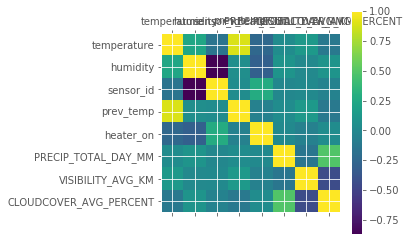

In [335]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

data_corelation = data.copy()
corr_matrix = data_corelation.corr()
plt.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.colorbar()
plt.show()

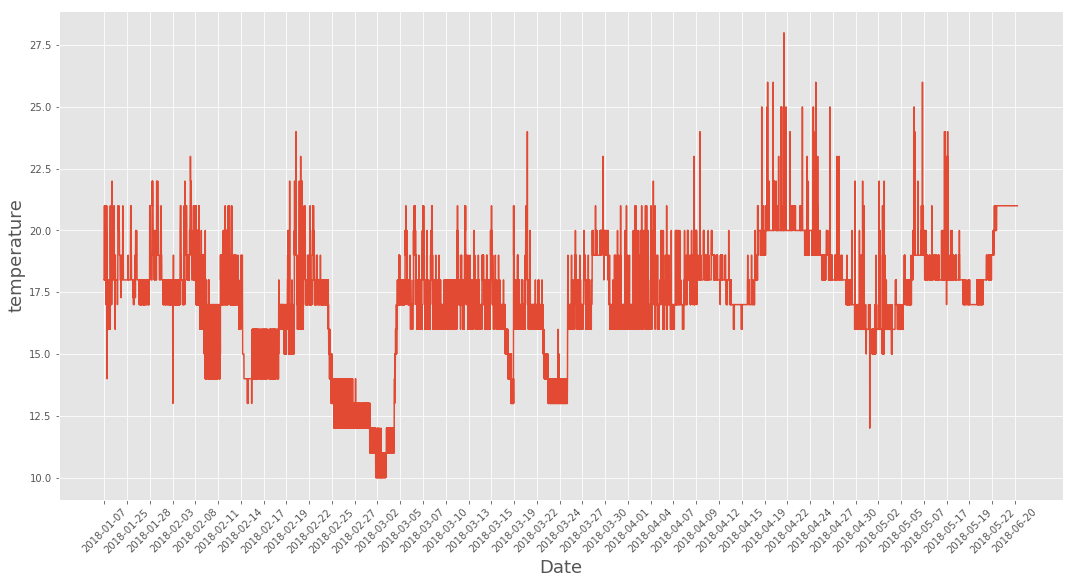

In [336]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]), data['temperature'])
plt.xticks(range(0,data.shape[0],500),data['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('temperature',fontsize=18)
plt.show()

In [337]:
data['hour'] = data['hour'].apply(lambda x: int(x.split(':')[0])*3600+int(x.split(':')[1])*60)
data['date'] = data['date'].apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d").timetuple()) - time.mktime(datetime.datetime.strptime(x.split('-')[0], "%Y").timetuple()))
data = pd.get_dummies(columns=['OPINION'], data=data)

In [338]:
from sklearn.preprocessing import MinMaxScaler

X = data[data.columns.drop('temperature')]
scaler_x = MinMaxScaler()
X_scale = scaler_x.fit_transform(X)

y = data['temperature']

/home/sebastien/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [339]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create training dataset
train_X, test_X, train_y, test_y = train_test_split(X_scale, y, random_state = 1)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb_model = XGBRegressor(base_score=0.9, booster='gbtree', learning_rate=0.48, max_depth = 7)
xgb_model.fit(train_X, train_y, verbose=False)
val_pred = xgb_model.predict(test_X)
xgb_score = xgb_model.score(test_X, test_y)

print(mean_squared_error(val_pred, test_y))
print(xgb_score)

0.17780211693566314
0.9625909679927767


Index(['date', 'humidity', 'sensor_id', 'prev_temp', 'hour', 'heater_on',
       'MAX_TEMPERATURE_C', 'MIN_TEMPERATURE_C', 'WINDSPEED_MAX_KMH',
       'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C',
       'PRECIP_TOTAL_DAY_MM', 'HUMIDITY_MAX_PERCENT', 'VISIBILITY_AVG_KM',
       'PRESSURE_MAX_MB', 'CLOUDCOVER_AVG_PERCENT', 'HEATINDEX_MAX_C',
       'DEWPOINT_MAX_C', 'WINDTEMP_MAX_C', 'WEATHER_CODE_MORNING',
       'WEATHER_CODE_NOON', 'WEATHER_CODE_EVENING', 'OPINION_météo correcte',
       'OPINION_météo défavorable', 'OPINION_météo favorable',
       'OPINION_météo idéale', 'OPINION_météo très défavorable'],
      dtype='object')


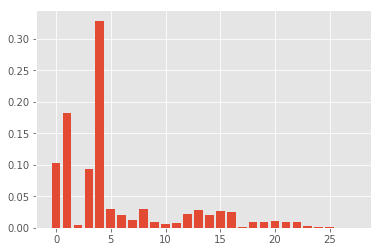

In [340]:
print(X.columns)
pyplot.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
pyplot.show()